In [1]:
import wandb
import pandas as pd

import torch
import torch.optim as optim
import numpy as np

In [2]:
entity="miki-and-tml"
project="scaling-tests"
api = wandb.Api()

runs = api.runs(f"{entity}/{project}")

dtypes = {
    'run_id': str, # or 'object'
    'val_loss': float, # or 'float64'
    'val_loss_ci_lower': float,
    'val_loss_ci_upper': float,
    'tokens_seen': int, # or 'int64'
    'compute': float,
    'params': int
}

# 2. Create the empty DataFrame, using keys from dtypes as columns
runs_df = pd.DataFrame(columns=dtypes.keys())

for run in runs:
    summary = run.summary._json_dict
    
    # Extract final logged values, defaulting to None if not available
    row = {
        'run_id': run.id,
        'run_name': run.name,
        'val_loss': summary.get('val_loss'),
        'val_loss_ci_lower': summary.get('val_loss_ci_lower'),
        'val_loss_ci_upper': summary.get('val_loss_ci_upper'),
        'tokens_seen': summary.get('tokens_seen'),
        'compute': summary.get('compute'),
        'params': summary.get('params'),
    }
    # Insert at the beginning - index 0
    runs_df = pd.concat([pd.DataFrame([row]), runs_df]).reset_index(drop=True)

runs_df


wandb: Currently logged in as: vanousekmikulas (vanousekmikulas-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/tmp/ipykernel_1077250/3146412732.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  runs_df = pd.concat([pd.DataFrame([row]), runs_df]).reset_index(drop=True)


,run_id,run_name,val_loss,val_loss_ci_lower,val_loss_ci_upper,tokens_seen,compute,params
0,trpthkjy,model_13.8M_tokens_240.0M,2.288926,2.286983,2.290807,239992832,3503818549493760,13797376
1,un2r3s60,model_13.8M_tokens_960.0M,1.973194,1.971443,1.974938,836730880,12216003094118400,None
2,fyrf1kaa,model_13.8M_tokens_480.0M,2.105506,2.103717,2.107332,479993856,7007756699566080,13797376
3,peysmra6,model_13.8M_tokens_120.0M,2.520611,2.518621,2.522644,119996416,1751909274746880,13797376
4,hglkjjir,model_6.8M_tokens_240.0M,2.507171,2.505203,2.509180,239992832,1958402947284992,6840320
5,44s405hw,model_6.8M_tokens_480.0M,2.308251,2.306353,2.310215,479993856,3916872743387136,6840320
6,v4cjr5tm,model_6.8M_tokens_120.0M,2.775165,2.773141,2.777215,119996416,979201473642496,6840320
7,glsgpd2b,model_6.8M_tokens_60.0M,3.130748,3.128711,3.132841,59998208,489600736821248,6840320
8,7ycev862,model_6.8M_tokens_30.0M,3.544189,3.542138,3.546343,29999104,244800368410624,6840320
9,bva60ie5,model_13.8M_tokens_60.0M,2.835036,2.832970,2.837153,59998208,875954637373440,13797376


In [3]:
print("There are ", len(runs_df), " runs")
runs_df_finished = runs_df[runs_df['params'].notnull()]
print("There are ", len(runs_df_finished), " finished runs")
runs_df = runs_df_finished
runs_df = runs_df.astype(dtypes)

There are  15  runs
There are  14  finished runs


In [ ]:
import torch.nn as nn
class ScalingLaw(torch.nn.Module):
    """
    We model the loss as a function of number of parameters N and dataset size D as:
    $$
    \hat{L}(N, D) \triangleq E+\frac{A}{N^\alpha}+\frac{B}{D^\beta}
    $$
    """
    def __init__(self, a=0.0, b=0.0, e=0.0, alpha=0.5, beta=0.5):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float32))
        self.e = nn.Parameter(torch.tensor(e, dtype=torch.float32))
        self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))

    def forward(self, N, D):
        """
        N: tensor of model sizes (number of parameters)
        D: tensor of dataset sizes
        returns: predicted loss (same shape as N and D)
        """
        A = torch.exp(self.a)
        B = torch.exp(self.b)
        E = torch.exp(self.e)
        return E + A / (N ** self.alpha) + B / (D ** self.beta)

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1077250/1335293162.py:6: SyntaxWarning: invalid escape sequence '\h'
  \hat{L}(N, D) \triangleq E+\frac{A}{N^\alpha}+\frac{B}{D^\beta}


In [25]:
N = torch.tensor(pd.to_numeric(runs_df['params']).values, dtype=torch.float32)
D = torch.tensor(pd.to_numeric(runs_df['tokens_seen']).values, dtype=torch.float32)
L = torch.tensor(runs_df['val_loss'].values, dtype=torch.float32)
X = torch.cat([N.unsqueeze(1), D.unsqueeze(1)], dim=1)
y = L

criterion = nn.HuberLoss(delta=1e-3)
total_epochs = 10000
learning_rate = 1e-3

# Containers for results
preds = torch.zeros_like(y)

models = []
for i in range(len(X)):
    print(f"LOOCV: leaving out sample {i+1}/{len(X)}")

    # Split train/val
    train_mask = torch.ones(len(X), dtype=bool)
    train_mask[i] = False

    X_train, y_train = X[train_mask], y[train_mask]
    X_val, y_val = X[~train_mask], y[~train_mask]

    # Initialize new model for each fold
    model = ScalingLaw()
    optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-9)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)

    # --- Train ---
    for epoch in range(total_epochs):
        model.train()
        optimizer.zero_grad()
        L_pred = model(X_train[:, 0], X_train[:, 1])
        loss = criterion(torch.log(L_pred), torch.log(y_train))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    # --- Predict on left-out sample ---
    model.eval()
    with torch.no_grad():
        pred = model(X_val[:, 0], X_val[:, 1])
        preds[i] = pred
    models.append(model)

# Write results back to the dataframe
runs_df['pred'] = preds.detach().numpy().flatten()
runs_df['error_abs'] = (runs_df['pred'] - runs_df['val_loss']).abs()
runs_df['error_rel'] = runs_df['error_abs'] / runs_df['val_loss']

# Show results sorted by largest absolute error
result_df = runs_df[['run_name', 'val_loss', 'pred', 'error_abs', 'error_rel']] \
    .sort_values(by='error_abs', ascending=False)
result_df


LOOCV: leaving out sample 1/14
LOOCV: leaving out sample 2/14
LOOCV: leaving out sample 3/14
LOOCV: leaving out sample 4/14
LOOCV: leaving out sample 5/14
LOOCV: leaving out sample 6/14
LOOCV: leaving out sample 7/14
LOOCV: leaving out sample 8/14
LOOCV: leaving out sample 9/14
LOOCV: leaving out sample 10/14
LOOCV: leaving out sample 11/14
LOOCV: leaving out sample 12/14
LOOCV: leaving out sample 13/14
LOOCV: leaving out sample 14/14


,run_name,val_loss,pred,error_abs,error_rel
14,model_1.8M_tokens_6.8M,5.251832,5.405519,0.153687,0.029263
12,model_1.8M_tokens_27.0M,4.279519,4.177402,0.102118,0.023862
10,model_1.8M_tokens_108.0M,3.419415,3.494396,0.074981,0.021928
11,model_1.8M_tokens_54.0M,3.827768,3.756294,0.071474,0.018673
8,model_6.8M_tokens_30.0M,3.544189,3.489066,0.055123,0.015553
9,model_13.8M_tokens_60.0M,2.835036,2.882710,0.047675,0.016816
5,model_6.8M_tokens_480.0M,2.308251,2.355834,0.047584,0.020615
2,model_13.8M_tokens_480.0M,2.105506,2.058929,0.046576,0.022121
7,model_6.8M_tokens_60.0M,3.130748,3.097344,0.033404,0.010670
3,model_13.8M_tokens_120.0M,2.520611,2.553108,0.032497,0.012893


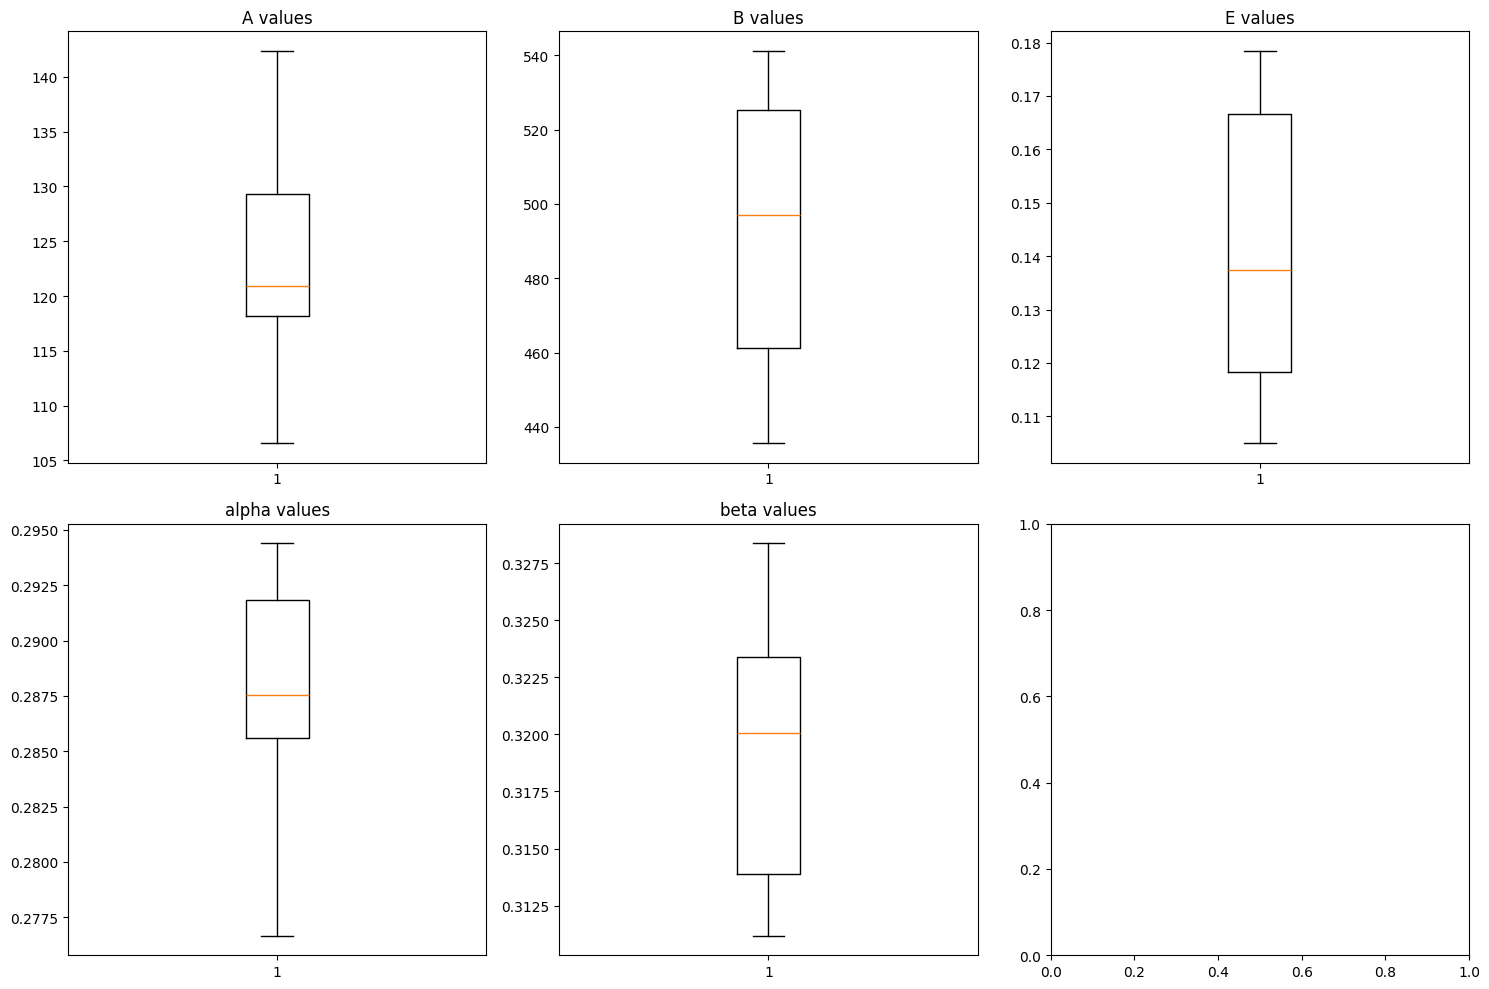

In [31]:
from math import exp
As = np.array([exp(m.a.item()) for m in models])
Bs = np.array([exp(m.b.item()) for m in models])
Es = np.array([exp(m.e.item()) for m in models])
alphas = np.array([m.alpha.item() for m in models])
betas = np.array([m.beta.item() for m in models])

# Boxplots of the parameters
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].boxplot(As)
axs[0, 0].set_title('A values')
axs[0, 1].boxplot(Bs)
axs[0, 1].set_title('B values')
axs[0, 2].boxplot(Es)
axs[0, 2].set_title('E values')
axs[1, 0].boxplot(alphas)
axs[1, 0].set_title('alpha values')
axs[1, 1].boxplot(betas)
axs[1, 1].set_title('beta values')
plt.tight_layout()
plt.show()

In [30]:
 
total_epochs = 20000
model = ScalingLaw()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epochs)
for epoch in range(total_epochs):
    model.train()
    optimizer.zero_grad()
    L_pred = model(N, D)
    loss = criterion(torch.log(L_pred), torch.log(L))
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.00113853404764086
Epoch 100, Loss: 0.00103435677010566
Epoch 200, Loss: 0.0007221602136269212
Epoch 300, Loss: 0.00021898090199101716
Epoch 400, Loss: 0.00021814831416122615
Epoch 500, Loss: 0.00021739389922004193
Epoch 600, Loss: 0.0002165842888643965
Epoch 700, Loss: 0.0002157040871679783
Epoch 800, Loss: 0.00021474735694937408
Epoch 900, Loss: 0.0002137128176400438
Epoch 1000, Loss: 0.00021260084758978337
Epoch 1100, Loss: 0.00021141186880413443
Epoch 1200, Loss: 0.0002101461577694863
Epoch 1300, Loss: 0.0002088036562781781
Epoch 1400, Loss: 0.00020738379680551589
Epoch 1500, Loss: 0.00020588569168467075
Epoch 1600, Loss: 0.00020430792937986553
Epoch 1700, Loss: 0.0002026489091804251
Epoch 1800, Loss: 0.00020090640464331955
Epoch 1900, Loss: 0.00019907784007955343
Epoch 2000, Loss: 0.00019716005772352219
Epoch 2100, Loss: 0.00019514966697897762
Epoch 2200, Loss: 0.00019304260786157101
Epoch 2300, Loss: 0.00019083451479673386
Epoch 2400, Loss: 0.00018852078937925398


In [35]:
preds = model(N, D)
runs_df['pred'] = preds.detach().numpy()
runs_df['error_abs'] = (runs_df.pred - runs_df.val_loss).abs()
runs_df['error_rel'] = runs_df.error_abs / runs_df.val_loss
runs_df[['run_name', 'val_loss', 'pred', 'error_abs', 'error_rel']].sort_values(by='error_abs', ascending=False)

,run_name,val_loss,pred,error_abs,error_rel
12,model_1.8M_tokens_27.0M,4.279519,4.200587,0.078932,0.018444
14,model_1.8M_tokens_6.8M,5.251832,5.323433,0.071601,0.013634
2,model_13.8M_tokens_480.0M,2.105506,2.066022,0.039484,0.018753
11,model_1.8M_tokens_54.0M,3.827768,3.790504,0.037264,0.009735
10,model_1.8M_tokens_108.0M,3.419415,3.456645,0.037230,0.010888
8,model_6.8M_tokens_30.0M,3.544189,3.507761,0.036427,0.010278
9,model_13.8M_tokens_60.0M,2.835036,2.867541,0.032505,0.011465
3,model_13.8M_tokens_120.0M,2.520611,2.543989,0.023378,0.009275
7,model_6.8M_tokens_60.0M,3.130748,3.110397,0.020351,0.006500
4,model_6.8M_tokens_240.0M,2.507171,2.523396,0.016225,0.006472


In [36]:
A = torch.exp(model.a).item()
B = torch.exp(model.b).item()
E = torch.exp(model.e).item()
alpha = model.alpha.item()
beta = model.beta.item()
print(f"A={A}, B={B}, E={E}, alpha={alpha}, beta={beta}")

A=171.82716369628906, B=352.33856201171875, E=0.1401507556438446, alpha=0.31393054127693176, beta=0.29646673798561096
